In [15]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from imutils import paths
import pandas as pd
image = cv2.imread('a3_45.png')
image.shape

(750, 7522, 3)

In [2]:
def show_graph(x_list, y_list, width, height):
    plt.figure(figsize = [width, height]) 
    plt.scatter(x_list, y_list, marker='.', s=5)
    plt.show()
    return

In [ ]:
x_list, y_list = [], []
for x in np.arange(0, 7522, 1):
    for y in np.arange(0, 750, 1):
        if np.all(image[y][x] == (0, 0, 0)):
            x_list.append(x)
            y_list.append(750-y)


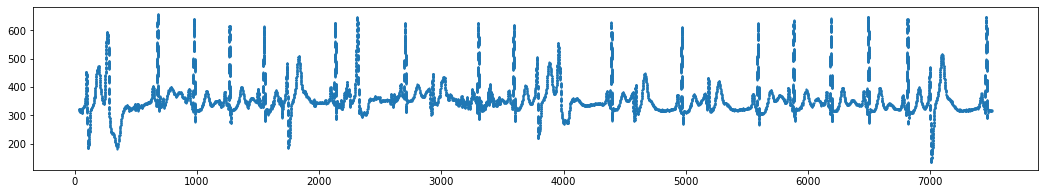

In [7]:
show_graph(x_list, y_list, 18, 3)

In [8]:
print(image[0][0])   # coordinate format is [y][x]
print(image[749][7521])

[255 255 255]
[255 255 255]


In [9]:
def locate_pos(image, color):
    position_list = []
    y_level = 42
    while len(position_list) == 0 and y_level < 100:
        x=100
        while x<7422:
            if np.all(image[y_level][x] == color):
                position_list.append(x)
                x += 25
            x += 1
        y_level+=2
    return position_list

In [10]:
def extract_feat(image, begin, end):
    x_list, y_list = [], [0]   # boundary padding add '0'
    for x in np.arange(begin, end, 1):
        x_list.append(x-begin)
        for y in np.arange(0, 750, 1):
            if np.all(image[y][x] == (0, 0, 0)):
                y_list.append(750-y)
                break
            if y==749:
                y_list.append(y_list[x-begin])
    y_list.pop(0)   # remove boundary padding '0'
    show_graph(x_list, y_list, 2, 2)
    return y_list

In [11]:
from statistics import mean, median
def find_stats(y_list, begin, end):
    temp = []
    for i in np.arange(begin, end, 1):
        temp.append(y_list[i])
    return [min(temp), mean(temp), median(temp), max(temp)]

In [12]:
def extract_feat(image, begin, end):
    x_list, y_list = [], [0]   # boundary padding add '0'
    for x in np.arange(begin, end, 1):
        x_list.append(x-begin)
        for y in np.arange(0, 750, 1):
            if np.all(image[y][x] == (0, 0, 0)):
                y_list.append(750-y)
                break
            if y==749:
                y_list.append(y_list[x-begin])
    y_list.pop(0)   # remove boundary padding '0'
    
    y_list.extend(find_stats(y_list, 0, 40))   # quardrant 1
    y_list.extend(find_stats(y_list, 40, 80))   # quardrant 2
    y_list.extend(find_stats(y_list, 80, 120))   # quardrant 3
    y_list.extend(find_stats(y_list, 120, 160))   # quardrant 4
    y_list.extend(find_stats(y_list, 0, 80))   # segment 1
    y_list.extend(find_stats(y_list, 40, 120))   # segment 2
    y_list.extend(find_stats(y_list, 80, 160))   # segment 3
    
    return y_list

In [ ]:
train_X, train_y = [], []   # initialise for features extraction
imagePaths = sorted(list(paths.list_images('C:/ECG/train1/train')))
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    
    position_list = locate_pos(image, (0, 128, 0)) # V
    count = len(position_list)
    for i in range(count):
        train_X.append(extract_feat(image, 
                position_list[i]-70, position_list[i]+90))
        train_y.append(1)
    position_list = locate_pos(image, (255, 0, 0)) # N
    for i in range(count):
        train_X.append(extract_feat(image, 
                position_list[i]-70, position_list[i]+90))
        train_y.append(0)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=.2, random_state=SEED)
logit = LogisticRegression(C = 0.001)
logit.fit(X_train, y_train)
y_pred = (logit.predict_proba(X_test)[:,1] >= 0.026)
print(f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [ ]:
import pickle
pickle.dump(logit, open('logistic_model.pickle', 'wb'))

In [ ]:
filename_list = []
location_list = []
imagePaths = sorted(list(paths.list_images('test')))
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    filename_list.append(imagePath)
    position_list = locate_pos(image, (255, 0, 0))
    count = len(position_list)
    
    test_X = []
    if count > 0:
        for i in range(count):
            test_X.append(extract_feat(image, position_list[i]-75, position_list[i]+85))
        y_pred = logit.predict(test_X)
        
    timing = []
    for i in range(len(y_pred)):
        if y_pred[i] == 1:
            timing.append((position_list[i]-36)*(20/7450))
    location_list.append(timing_list)

In [ ]:
df = pd.DataFrame()
df['filename'] = filename_list
df['location(sec)'] = location_list
df.to_csv('test_results.csv', index=False)